# Multi-Label Classification
---
## Plant Seedling Classification

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = 'data/plant/'

In [4]:
ls{PATH}

sample_submission.csv.zip  test/  train/


In [5]:
files = !ls {PATH}train/**/*.png
files[0:10]

['data/plant/train/Black-grass/0050f38b3.png',
 'data/plant/train/Black-grass/0183fdf68.png',
 'data/plant/train/Black-grass/0260cffa8.png',
 'data/plant/train/Black-grass/05eedce4d.png',
 'data/plant/train/Black-grass/075d004bc.png',
 'data/plant/train/Black-grass/078eae073.png',
 'data/plant/train/Black-grass/082314602.png',
 'data/plant/train/Black-grass/0ace21089.png',
 'data/plant/train/Black-grass/0b228a6b8.png',
 'data/plant/train/Black-grass/0b3e7a7a9.png']

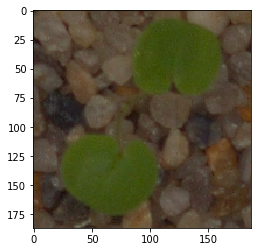

In [6]:
# Pick an image out at random
img = plt.imread(files[random.randint(0,len(files))])
plt.imshow(img);

## Create Label File
---
### Iterate through training dataset and count the number of files in each subdirectory

In [7]:
ls{'data/plant/train'}

Black-grass/  Common Chickweed/  Loose Silky-bent/   Shepherds Purse/
Charlock/     Common wheat/      Maize/              Small-flowered Cranesbill/
Cleavers/     Fat Hen/           Scentless Mayweed/  Sugar beet/


In [8]:
from glob import glob
import pandas as pd

df = pd.DataFrame(columns=["file", "species"])

for image in glob(f'{PATH}train/**/*.png'):
    dir_ = image.split('/')
    file_, species = dir_[-1], dir_[-2]

    df = df.append({
        "file": file_,
        "species": species
        }, ignore_index=True)

df.to_csv('labels.csv', index=False)

In [9]:
df.head(10)

,file,species
0,e82c4271a.png,Small-flowered Cranesbill
1,8ee5d6835.png,Small-flowered Cranesbill
2,d7ecdaabe.png,Small-flowered Cranesbill
3,985e72cfb.png,Small-flowered Cranesbill
4,2a1966ff8.png,Small-flowered Cranesbill
5,29ed37400.png,Small-flowered Cranesbill
6,feea57708.png,Small-flowered Cranesbill
7,04559c69c.png,Small-flowered Cranesbill
8,5861480ff.png,Small-flowered Cranesbill
9,0ff5ac7e1.png,Small-flowered Cranesbill


In [11]:
ls{PATH}

sample_submission.csv.zip  test/  train/


## Data Augmentation
---
### Switch to data/seedlings/ folder

In [12]:
PATH = 'data/seedlings/'

In [13]:
ls{PATH}

adas-submission-2.csv  labels.csv             submission2.csv  tmp/
adas-submission.csv    models/                submission.csv   train/
labels2.csv            sample_submission.csv  test/


In [14]:
df2 = pd.read_csv('labels.csv')
df.head(10)

,file,species
0,e82c4271a.png,Small-flowered Cranesbill
1,8ee5d6835.png,Small-flowered Cranesbill
2,d7ecdaabe.png,Small-flowered Cranesbill
3,985e72cfb.png,Small-flowered Cranesbill
4,2a1966ff8.png,Small-flowered Cranesbill
5,29ed37400.png,Small-flowered Cranesbill
6,feea57708.png,Small-flowered Cranesbill
7,04559c69c.png,Small-flowered Cranesbill
8,5861480ff.png,Small-flowered Cranesbill
9,0ff5ac7e1.png,Small-flowered Cranesbill


PyTorch doesn't like species names with spaces in them. We need to use a bit of regex-fu to replace the blank spaces with '-'

In [15]:
df3 = df2.copy()
df3.replace('\s+', '-',regex=True,inplace=True)
df3.to_csv('data/seedlings/labels2.csv', index=False)

## Create image augmentations
---
### Allows the model to learn from viewing the same image from different angles - equivalent to bootstrapping.

In [19]:
sz = 400 # image size
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)

In [20]:
def get_augs():
    data = ImageClassifierData.from_csv(PATH, folder='train', csv_fname=f'{PATH}labels2.csv',
                                        val_idxs=get_cv_idxs(n=4750), bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

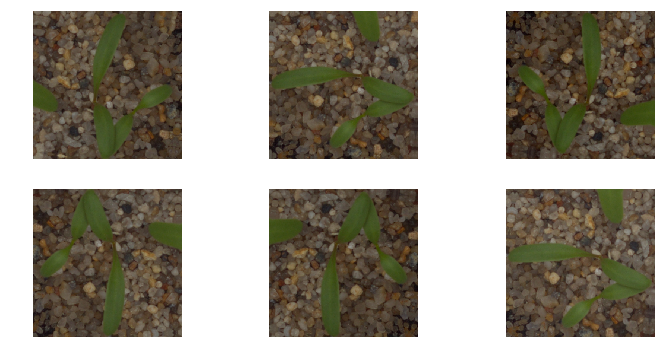

In [21]:
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

## Train the base model

In [23]:
bs = 12 # batch size
arch = resnet50 # ResNet50 model
lr = 0.01 # Learning Rate

In [24]:
tfms = tfms
data = ImageClassifierData.from_csv(PATH, folder='train', csv_fname=f'{PATH}labels2.csv',
                                    tfms=tfms, val_idxs=get_cv_idxs(n=4750), test_name='test', bs=bs)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(lr, 10)

100%|██████████| 67/67 [00:22<00:00,  2.98it/s]


HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.108468   0.669549   0.78125   
    1      0.833939   0.430778   0.848958                     
    2      0.708319   0.386554   0.870833                     
    3      0.543265   0.35568    0.882292                     
    4      0.4936     0.308557   0.894792                     
    5      0.471737   0.30771    0.897917                     
    6      0.441906   0.284558   0.910417                     
    7      0.354909   0.294525   0.896875                     
    8      0.386905   0.316884   0.873958                     
    9      0.360345   0.355608   0.8875                       



[0.35560825, 0.8875000022351742]

In [25]:
# Create a learner function to determine the optimal learning rate
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [26]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 70%|██████▉   | 221/317 [00:01<00:00, 122.88it/s, loss=8.01]


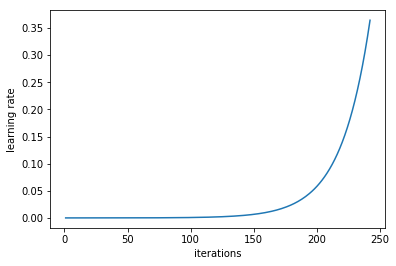

In [27]:
learn.sched.plot_lr()

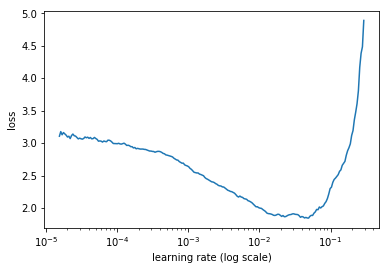

In [28]:
# plot of loss versus learning rate
learn.sched.plot()

In [30]:
# Don't take the learning rate at the minimum.
# Take it slightly to the left  so that we are still moving in the direction
# of the minimum.
learn.fit(1e-3, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.731111   0.409081   0.854167  



[0.4090809, 0.8541666693985462]

### Improving our model
---

In [31]:
# Turn precompute off
learn.precompute=False

In [34]:
# Retrain model for 5 epochs where cycle_len = 1
learn.fit(1e-3, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.715741   0.366897   0.873958  
    1      0.65799    0.350848   0.873958                    
    2      0.643363   0.346791   0.882292                    
    3      0.641363   0.339236   0.882292                    
    4      0.657865   0.329322   0.889583                    



[0.32932174, 0.8895833343267441]

We're doing quite well after 5 epochs. 89% accuracy and our training loss is greater than our validation loss which means we're not overfitting.

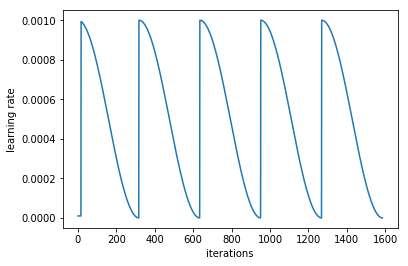

In [35]:
learn.sched.plot_lr()

In [36]:
learn.save('400_lastlayer')

In [37]:
learn.load('400_lastlayer')

In [38]:
# unfreeze earlier layers
learn.unfreeze()

In [39]:
# Set differential learning rates
lr = 1e-3
lrs=np.array([lr/18, lr/6, lr/2])

In [40]:
# Learn at these rates
learn.fit(lrs, 3, cycle_len=2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.459785   0.22107    0.915625  
    1      0.397486   0.186459   0.9375                      
    2      0.337491   0.142164   0.946875                    
    3      0.280816   0.129287   0.955208                    
    4      0.239935   0.113069   0.954167                    
    5      0.266505   0.112646   0.957292                    
    6      0.271816   0.114637   0.958333                    
    7      0.212947   0.104778   0.959375                    
    8      0.186143   0.095038   0.963542                    
    9      0.163779   0.081413   0.972917                    
    10     0.133223   0.083391   0.967708                    
    11     0.110366   0.079054   0.96875                     
    12     0.144109   0.07869    0.972917                    
    13     0.140309   0.07804    0.971875                    



[0.078039505, 0.9718750029802322]

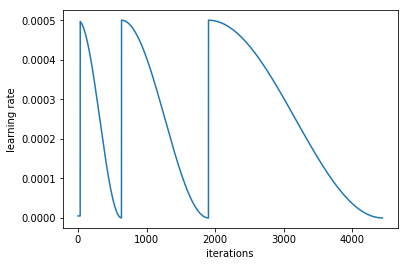

In [41]:
learn.sched.plot_lr()

In [42]:
learn.save('resnet50_400_all')

In [43]:
learn.load('resnet50_400_all')

In [44]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.268434   0.110267   0.961458  
    1      0.255436   0.112835   0.957292                    
    2      0.175224   0.08095    0.973958                    
    3      0.221457   0.093065   0.95625                     
    4      0.129169   0.065989   0.975                       
    5      0.132563   0.056086   0.982292                     
    6      0.079332   0.056938   0.984375                     



[0.056937717, 0.9843750029802323]

Cool - now we're getting an accuracy above 98% while still keeping our training loss above our validation loss (not overfitting)

### Using Test Time Augmentation
---

In [45]:
log_preds, y = learn.TTA(n_aug=3)

In [48]:
# Take exponential and take the average
preds = np.mean(np.exp(log_preds), 0)

In [49]:
preds

array([[0.0001 , 0.00003, 0.00003, ..., 0.     , 0.     , 0.99944],
       [0.     , 0.00002, 0.00015, ..., 0.     , 0.     , 0.99814],
       [0.00008, 0.01556, 0.93958, ..., 0.00057, 0.02699, 0.00089],
       ...,
       [0.03201, 0.00152, 0.00049, ..., 0.003  , 0.0185 , 0.00634],
       [0.00299, 0.     , 0.00001, ..., 0.     , 0.     , 0.     ],
       [0.     , 0.99997, 0.     , ..., 0.     , 0.     , 0.00001]], dtype=float32)

In [50]:
probs = np.exp(log_preds)

In [51]:
probs

array([[[0.00003, 0.     , 0.00001, ..., 0.     , 0.     , 0.99991],
        [0.     , 0.00002, 0.00004, ..., 0.     , 0.     , 0.99902],
        [0.00007, 0.0298 , 0.92891, ..., 0.00014, 0.01246, 0.0021 ],
        ...,
        [0.10601, 0.00548, 0.00108, ..., 0.00736, 0.00219, 0.02408],
        [0.00411, 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
        [0.00001, 0.99994, 0.     , ..., 0.     , 0.     , 0.00003]],

       [[0.00034, 0.00011, 0.00008, ..., 0.     , 0.00001, 0.99806],
        [0.     , 0.00002, 0.00008, ..., 0.     , 0.     , 0.99867],
        [0.00007, 0.01445, 0.92067, ..., 0.00113, 0.05808, 0.00044],
        ...,
        [0.00524, 0.00035, 0.00022, ..., 0.00077, 0.0381 , 0.00089],
        [0.00258, 0.     , 0.00002, ..., 0.     , 0.     , 0.     ],
        [0.     , 1.     , 0.     , ..., 0.     , 0.     , 0.     ]],

       [[0.00003, 0.     , 0.00001, ..., 0.     , 0.     , 0.9999 ],
        [0.     , 0.00001, 0.00002, ..., 0.     , 0.     , 0.99896],
    

In [55]:
# see accuracy
accuracy_np(preds, y)

0.9842105263157894

In [52]:
log_preds_test = learn.predict(is_test=True)
log_preds_test.shape

(794, 12)

In [53]:
metrics.log_loss(y,preds), accuracy_np(preds, y)

(0.05886647253750793, 0.9842105263157894)

In [56]:
# get test predictions
test_preds = learn.TTA(n_aug=5, is_test=True)

### Save results and submit to kaggle
---

In [61]:
log_preds_test = np.argmax(log_preds_test, axis=1)
preds_classes = [data.classes[i].replace("_", " ") for i in log_preds_test]
probs = np.exp(log_preds_test)

In [62]:
submission_final = pd.DataFrame({'file': os.listdir(f'{PATH}test'), 'species': preds_classes})
submission_final.head(10)

,file,species
0,3efa1f66c.png,Loose-Silky-bent
1,abc331628.png,Common-wheat
2,bdde957ec.png,Scentless-Mayweed
3,456d507c0.png,Cleavers
4,37714071b.png,Shepherds-Purse
5,2f0004a7f.png,Common-wheat
6,e1809cef2.png,Scentless-Mayweed
7,4f83143e1.png,Maize
8,4f44ca525.png,Common-Chickweed
9,17529c555.png,Scentless-Mayweed


In [63]:
submission_final.species.value_counts()

Loose-Silky-bent             114
Common-Chickweed             102
Scentless-Mayweed             92
Small-flowered-Cranesbill     80
Sugar-beet                    78
Fat-Hen                       63
Charlock                      62
Cleavers                      47
Black-grass                   45
Shepherds-Purse               43
Maize                         35
Common-wheat                  33
Name: species, dtype: int64

In [65]:
submission_final.to_csv('data/seedlings/adas-submission_final.csv', index=False)